In [ ]:
#%%
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
from torchvision.transforms import v2

from utils.diffeo_container import sparse_diffeo_container, diffeo_container

from tqdm import tqdm

device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")
print(device)

torch_seed = 37
t.manual_seed(torch_seed)

# setting up path and config
ImageNet_path = '/imagenet'
data_save_path = '/vast/xj2173/diffeo/model_accuracy'

num_of_images = 100

diffeo_strengths = [0, 0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175]

num_of_diffeo = 20

diffeo_freq_band_list = [[0,5], [10,11], [20,21], [30,31], [40,41]]

inference_res = 224
# setting up helper function

def get_model():
  model = tv.models.efficientnet_v2_s(weights = tv.models.EfficientNet_V2_S_Weights.DEFAULT).to(device)
  # ENV2 = tv.models.efficientnet_v2_s().to(device) # random initialization
  model.eval();
  for param in model.parameters():
      param.requires_grad = False
  return model

def get_inference_transform():
  inference_transform = tv.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1.transforms()
  inference_transforms = v2.Compose([
      lambda x: x.convert('RGB'),
      inference_transform,
  ])
  return inference_transforms

def get_ImageNet(transforms = None, batch_size = 1, shuffle = False):
  dataset = tv.datasets.ImageNet(ImageNet_path, split = 'val', transform = transforms)
  dataloader = t.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = shuffle)
  return dataset, dataloader

def get_diffeo_container(x_range, y_range, num_of_terms, diffeo_strength_list = None, num_of_didffeo = None, res = inference_res):
  diffeo_container = sparse_diffeo_container(res, res)
  for strength in diffeo_strength_list:
      diffeo_container.sparse_AB_append(x_range, y_range, num_of_terms, strength, num_of_didffeo)
  diffeo_container.get_all_grid()
  diffeo_container.to(device)
  return diffeo_container

def get_Images(dataLoader: "iterable", num_of_images = num_of_images):
  '''
  returns the images and the correct labels
  '''
  val_images = []
  labels = []
  for _ in range(num_of_images):
    image, label = next(dataLoader)
    val_images.append(image)
    labels.append(label)

  return t.cat(val_images), t.Tensor(labels)

def get_accuracy_for_band(model, 
                          loss_fn, 
                          val_images, 
                          labels,
                          diffeos,
                          batch_size):  

  total_batch = batch_size[0] * batch_size[1]

  loss = []
  accuracy = []

  for i, (image,label) in enumerate(tqdm(zip(val_images, labels), total = num_of_images)):

    distorted_list = diffeos(image.expand(total_batch, -1,-1,-1), in_inference = True)

    output = model(distorted_list)
    
    pred_classes = output.argmax(dim=1)

    label_view = label.expand(total_batch).type(t.int64)

    with t.no_grad():
      loss.append(loss_fn(output, label_view).view(batch_size[0], batch_size[1], -1))
      
    accuracy.append((pred_classes == label_view).float().view(batch_size[0], batch_size[1], -1))

  return t.stack(accuracy), t.stack(loss)


def unpack(data, bands, metadata = None):
    data_dict ={}
    for band_data, band in zip(data, bands):
        data_dict[str(band)] = band_data
    if metadata != None:
      for key, value in metadata.items():
        data_dict[key] = value
    return data_dict

cuda


In [20]:
model = get_model().to(device)

inf_transf = get_inference_transform()
dataset, dataloader = get_ImageNet(transforms = inf_transf, batch_size = 1, shuffle = True)
data_iter = iter(dataloader)

loss_fn = nn.CrossEntropyLoss(reduction = 'none')

print('model & dataset setup finished', flush = True)

val_images, labels = get_Images(data_iter)
val_images = val_images.to(device)
labels = labels.to(device)

ref_out = model(val_images) 
ref_accuracy = (ref_out.argmax(dim = 1) == labels).float()
ref_loss = loss_fn(ref_out, labels.type(t.int64))
#save ref_accuracy
#save ref_loss
print('reference computed')

acc_list = []
los_list = []
for band_limit in diffeo_freq_band_list:
    batch_size = [len(diffeo_strengths), num_of_diffeo]
    diffeos = get_diffeo_container(band_limit, band_limit, 1, diffeo_strengths, num_of_diffeo)
    accuracy, loss = get_accuracy_for_band(model, loss_fn, val_images, labels, diffeos, batch_size)
    acc_avg = t.mean(accuracy, dim = (0 , 2))
    loss_avg = t.mean(loss, dim = (0 , 2))
    
    acc_list.append(acc_avg.squeeze().cpu())
    los_list.append(loss_avg.squeeze().cpu())


# give names to save the commented out items!!!!!
# t.save(ref_accuracy)
# t.save(ref_loss)    

metadata = {'diffeo_strengths': diffeo_strengths,
            'num_of_images': num_of_images,
            'num_of_diffeo': num_of_diffeo,
            'inference_res': inference_res}

acc_dict = unpack(acc_list, diffeo_freq_band_list, metadata)
los_dict = unpack(los_list, diffeo_freq_band_list, metadata)

# t.save(acc_dict)
# t.save(los_dict)

model & dataset setup finished
reference computed


100%|██████████| 100/100 [00:24<00:00,  4.12it/s]


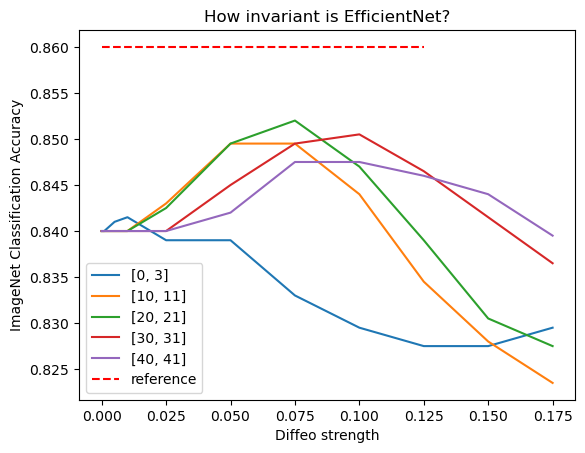

In [22]:
from matplotlib import pyplot as plt

plot_labels = [str(band) for band in diffeo_freq_band_list]

for data, name in zip(acc_list, plot_labels):
    plt.plot(diffeo_strengths, data, label = name)
plt.title('How invariant is EfficientNet?')
plt.xlabel('Diffeo strength')
plt.ylabel('ImageNet Classification Accuracy')
plt.hlines(ref_accuracy.mean().cpu(), xmin = 0, xmax = max(diffeo_strengths[:-2]), label = 'reference', color = 'r', linestyles= '--')
plt.legend(loc = 'lower left')

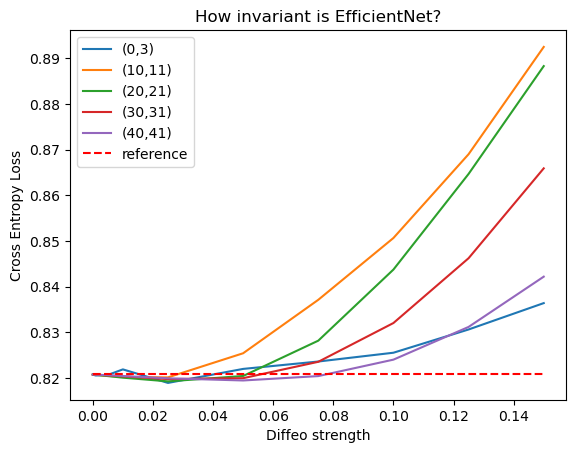

In [11]:
from matplotlib import pyplot as plt

for data, name in zip(los_list, plot_labels):
    plt.plot(diffeo_strengths[:-2], data[:-2], label = name)
plt.title('How invariant is EfficientNet?')
plt.xlabel('Diffeo strength')
plt.ylabel('Cross Entropy Loss')
plt.hlines(ref_loss.mean().cpu(), xmin = 0, xmax = max(diffeo_strengths[:-2]), label = 'reference', color = 'r', linestyles= '--')
plt.legend(loc = 'upper left')

In [5]:
loss_fn(output, label_view)

tensor(0.4127, device='cuda:0')

In [29]:
with t.no_grad():
    loss.append(loss_fn(output, label.expand(220).type(t.int64)).item())


In [21]:
label.expand(num_of_diffeo * len(diffeo_strengths),1).type(t.int64).shape

torch.Size([220, 1])